In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels): 
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False), # bias to false due to batchnorm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,bias=False), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.double_conv(x)

In [3]:
class UNET(nn.Module):
    def __init__(self, in_channels=3,out_channels=1,features=[64,128,256,512]): # out_channels = n_classes
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList() # creating two lists 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part 
        for feature in features:
            self.downs.append(DoubleConv(in_channels,feature))
            in_channels=feature

        # Up part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2,feature, kernel_size=2, stride=2)) # this value of kernel and stride doubles upsampling
            self.ups.append(DoubleConv(feature*2, feature))  # adding connections so *2

        self.bottleneck = DoubleConv(features[-1], features[-1]*2) # 512 and 1024
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
            skip_connections = []
            
            for down in self.downs:
                x = down(x)
                skip_connections.append(x)
                x = self.pool(x)

            x = self.bottleneck(x)
            skip_connections = skip_connections[::-1] # reversing list for upsample

            for idx in range(0, len(self.ups), 2): # 2 steps because up then double conv
                x = self.ups[idx](x)
                skip_connection  = skip_connections[idx//2] # recover initial skip_connection for concating

                if x.shape != skip_connection.shape:
                    x = TF.resize(x, size=skip_connection.shape[2:]) # start from 2 to end i.eg height and width
                concat_skip =  torch.cat((skip_connection, x), dim = 1) # concanating along channel dim
                x = self.ups[idx+1](concat_skip) # idx=upsample, idx+1=double_conv

            return self.final_conv(x)

            
                

In [4]:
def test():
    x = torch.randn((3,1,160,160))
    model = UNET(in_channels=1,out_channels=1)
    pred = model(x)
    print(pred.shape)
    print(x.shape)
    assert pred.shape == x.shape

if __name__ == '__main__':
    test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [5]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, resize_size=(256, 256), transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize_size = resize_size
        self.transforms = transforms
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        # Paths
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png"))

        # Load and resize with PIL
        image = Image.open(img_path).convert("RGB").resize(self.resize_size, Image.BILINEAR)
        mask = Image.open(mask_path).convert("L").resize(self.resize_size, Image.NEAREST)
        
        # Convert to numpy
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        mask[mask == 255.0] = 1.0

        # Apply transforms if any
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # To tensors
        image = torch.from_numpy(image).permute(2, 0, 1) / 255.0
        mask = torch.from_numpy(mask).long()

        return image, mask

In [6]:
image_dir = '/kaggle/input/carvana-image-masking-png/train_images'
mask_dir = '/kaggle/input/carvana-image-masking-png/train_masks'

images = os.listdir(image_dir)

# Split into 80% train, 20% validation
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Create datasets
train_dataset = CarvanaDataset(image_dir, mask_dir, transforms=None)
val_dataset = CarvanaDataset(image_dir, mask_dir, transforms=None)

# But restrict to only train/val images
train_dataset.images = train_imgs
val_dataset.images = val_imgs


In [7]:

train_loader = DataLoader(train_dataset, batch_size=4, num_workers=2, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=2, pin_memory=True, shuffle=False)


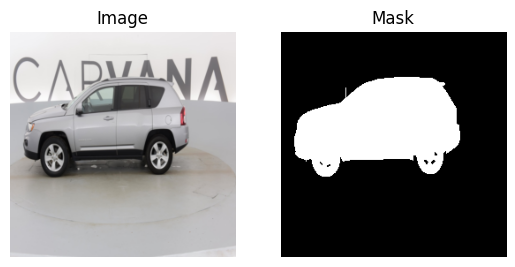

In [8]:
for img, mask in train_loader:
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask[0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()

    # optional: break if you only want the first batch
    break

In [9]:
def dice_loss(pred, target, smooth=1e-6):
    # Convert to probabilities
    pred = torch.sigmoid(pred)
    
    # Flatten
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    
    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth) # 2. for float multiplication
    
    return 1 - dice

# Dice metric (for evaluation)
def dice_score(pred, target, threshold=0.5, smooth=1e-6):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() 
                                           + smooth)


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNET().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),lr=1e-4,weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

In [11]:
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []

num_epochs = 10
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    total_loss_train = 0
    dice_score_train_sum = 0
    
    for image, mask in train_loader:
        image, mask = image.to(device), mask.to(device).float()
        
        # Add channel dimension to mask
        mask = mask.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
        
        output = model(image)  # [B, 1, H, W]
        
        # Calculate losses
        bce_loss_train = criterion(output, mask)
        dice_loss_train = dice_loss(output, mask)
        loss = bce_loss_train + dice_loss_train
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Calculate dice score
        probs = torch.sigmoid(output)
        dice_score_train_val = dice_score(probs, mask)
        dice_score_train_sum += dice_score_train_val.item()
        total_loss_train += loss.item()
    
    avg_train_loss = total_loss_train / len(train_loader)
    avg_dice_score_train = dice_score_train_sum / len(train_loader)
    
    # VALIDATION
    model.eval()
    total_loss_val = 0
    dice_score_val_sum = 0
    
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device).float()
            mask = mask.unsqueeze(1)
            
            output = model(image)
            
            bce_loss_val = criterion(output, mask)
            dice_loss_val = dice_loss(output, mask)
            loss_val = bce_loss_val + dice_loss_val
            
            probs = torch.sigmoid(output)
            dice_score_val_val = dice_score(probs, mask)
            dice_score_val_sum += dice_score_val_val.item()
            total_loss_val += loss_val.item()
    
    avg_val_loss = total_loss_val / len(val_loader)
    avg_dice_score_val = dice_score_val_sum / len(val_loader)

    scheduler.step()
    
    # Append metrics for plotting later
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_dice_scores.append(avg_dice_score_train)
    val_dice_scores.append(avg_dice_score_val)
    
    # Print progress
    print(f"Epoch {epoch+1}:")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_dice_score_train:.4f}")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Dice: {avg_dice_score_val:.4f}")


Epoch 1:
  Train - Loss: 0.3392, Dice: 0.9757
  Val   - Loss: 0.1633, Dice: 0.9795
Epoch 2:
  Train - Loss: 0.0855, Dice: 0.9905
  Val   - Loss: 0.0505, Dice: 0.9920
Epoch 3:
  Train - Loss: 0.0381, Dice: 0.9926
  Val   - Loss: 0.0308, Dice: 0.9923
Epoch 4:
  Train - Loss: 0.0254, Dice: 0.9931
  Val   - Loss: 0.0218, Dice: 0.9931
Epoch 5:
  Train - Loss: 0.0183, Dice: 0.9941
  Val   - Loss: 0.0168, Dice: 0.9942
Epoch 6:
  Train - Loss: 0.0153, Dice: 0.9945
  Val   - Loss: 0.0143, Dice: 0.9946
Epoch 7:
  Train - Loss: 0.0132, Dice: 0.9950
  Val   - Loss: 0.0140, Dice: 0.9946
Epoch 8:
  Train - Loss: 0.0127, Dice: 0.9950
  Val   - Loss: 0.0127, Dice: 0.9949
Epoch 9:
  Train - Loss: 0.0109, Dice: 0.9956
  Val   - Loss: 0.0118, Dice: 0.9952
Epoch 10:
  Train - Loss: 0.0102, Dice: 0.9958
  Val   - Loss: 0.0113, Dice: 0.9953


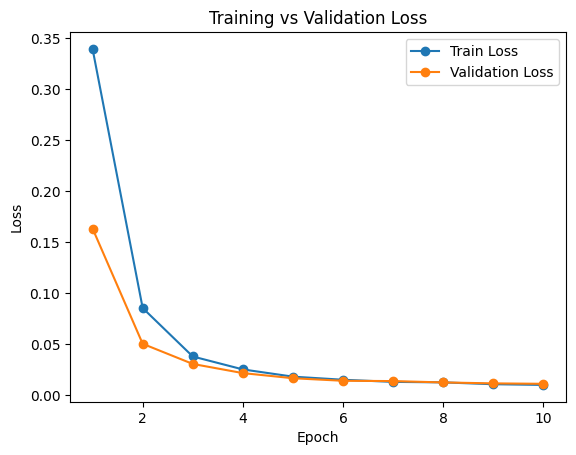

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

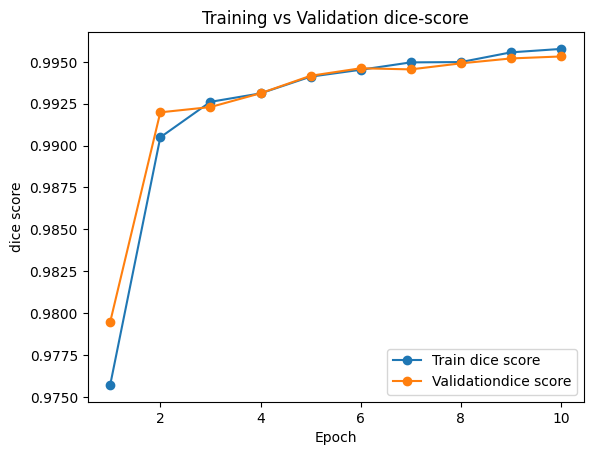

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), train_dice_scores, label="Train dice score", marker="o")
plt.plot(range(1, num_epochs+1), val_dice_scores, label="Validationdice score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("dice score")
plt.title("Training vs Validation dice-score")
plt.legend()
plt.show()

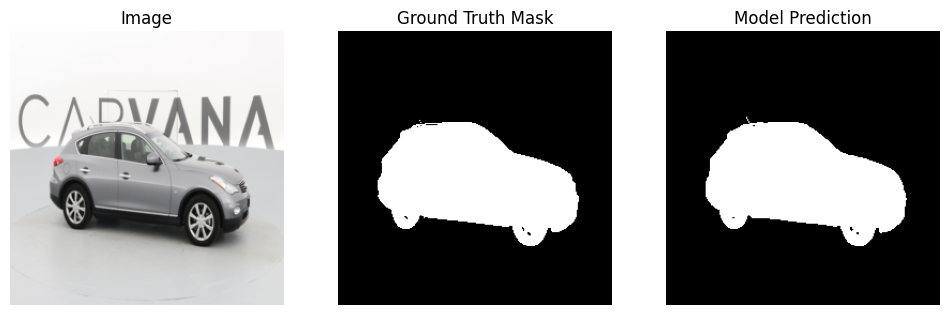

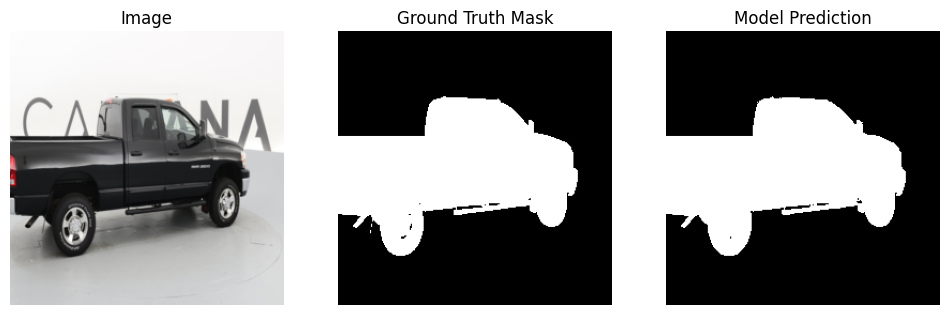

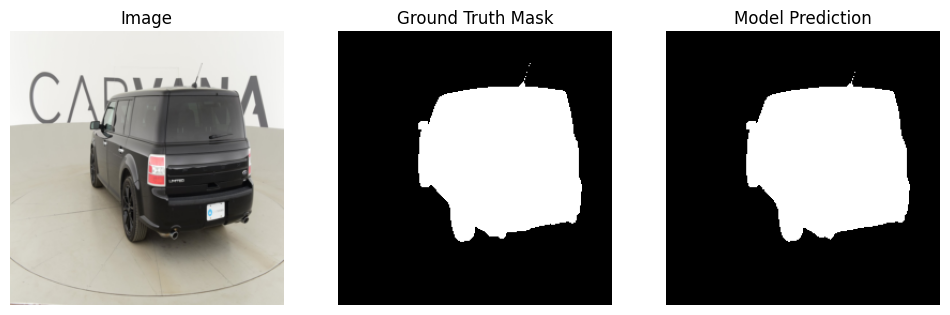

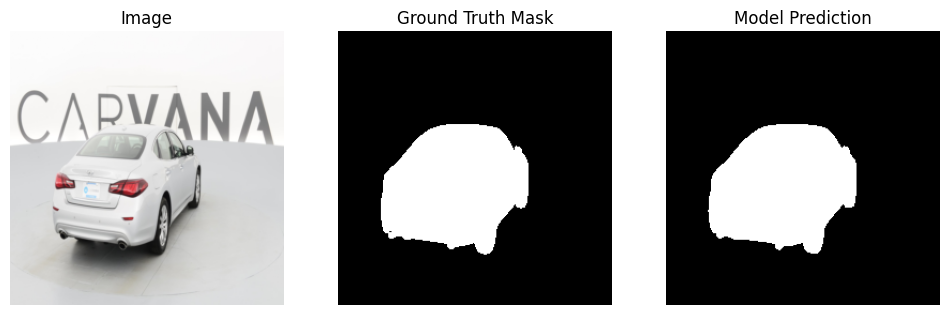

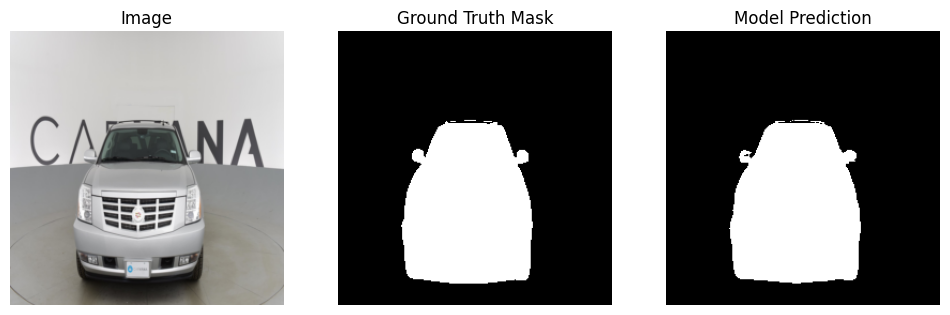

In [15]:
import matplotlib.pyplot as plt
import torch

# Pick 5 samples from validation loader
model.eval()
num_samples = 5

with torch.no_grad():
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_samples:
            break
        
        image, mask = image.to(device), mask.to(device).float()
        mask = mask.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
        
        # Forward pass
        output = model(image)
        probs = torch.sigmoid(output)
        preds = (probs > 0.5).float()  # threshold at 0.5
        
        # Convert tensors to CPU numpy arrays for plotting
        img_np = image[0].permute(1,2,0).cpu().numpy()   # [H,W,C]
        mask_np = mask[0,0].cpu().numpy()                # [H,W]
        pred_np = preds[0,0].cpu().numpy()               # [H,W]
        
        # Plot side by side
        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.imshow(img_np)
        plt.title("Image")
        plt.axis("off")
        
        plt.subplot(1,3,2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        plt.subplot(1,3,3)
        plt.imshow(pred_np, cmap="gray")
        plt.title("Model Prediction")
        plt.axis("off")
        
        plt.show()


# # Very good result.